### Imports

In [16]:
# import necessary libraries
import pandas as pd
import numpy as np
import os
import glob
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import StratifiedGroupKFold, train_test_split, cross_val_score
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

import optuna
import xgboost as xgb
import shap
import tensorflow as tf

from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D, Flatten, Dense, GlobalAveragePooling1D

In [17]:
# Seed value for the project.
seed_value = 42

In [18]:
# Outcome variables - as decided with the host organisation.
# These values correspond to a ventricular fibrillation.
OUTCOMES = [
'ATP in VT/VF delivered',
'ATP One Shot delivered',
'VT1 therapy episodes',
'VF episodes',
'ATP in VT zones started',
'ATP One Shot started',
'ATP in VT zones successful',
'ATP One Shot successful',
'Shocks started',
'Shocks aborted',
'Shocks successful']

# Feature variables specific to patients with single chamber ICDs (ventricular).
VENTR_FEATURES = ['RV pacing impedance [ohm]',
 'RV sensing amplitude (daily mean) [mV]',
 'RV sensing amplitude (daily min.) [mV]',
 'Daily shock lead impedance [ohm]',
 'Right ven. pacing (RVp) [%]',
 'VT1 monitoring episodes',
 'VT1 therapy episodes',
 'VT2 episodes',
 'VF episodes',
 'Episodes during temporary program',
 'ATP in VT zones started',
 'ATP in VT zones successful',
 'ATP One Shot started',
 'ATP One Shot successful',
 'Shocks started',
 'Shocks aborted',
 'Shocks successful',
 'Ineffective ven. max. energy shocks',
 'Mean ventricular heart rate [bpm]',
 'Mean ventricular heart rate at rest [bpm]',
 'Patient activity [% of day]',
 'ATP in VT/VF delivered',
 'ATP One Shot delivered']

#### Importing the data

In [20]:
outcome_df = pd.read_csv(os.getcwd()+'/cleaned_df.csv')

### Functions
**extract_intervals()** - performs resampling of the data  
**DataReshaper()** - class - reshapes a 3D dataset into 2D (sample, day x feature)  
**clean_feature_name()** - removes strings from feature names  
**reshape_for_resampl_mod()** - applies the DataReshaper, cleans and adds column names  
**running_resampl_models()** - function that runs the models and collects accuracy metrics  
**boot_conf_int()** - bootstrapped confidence interval calculation for ROC-AUC  
**sens_spec_calculation()** - sensitivity, specificity calculation at predetermined threshold  

In [6]:
def extract_intervals(more_dt, WINDOW_SIZE):
    '''
    Extracts intervals from patients' time series data. The function samples
    intervals of size WINDOW_SIZE and collects feature data along with outcome
    labels (shock values). If a patient is a case, then two or more samples are
    extracted from their data, if they are a control, only one interval is
    extracted. Lastly, it keeps track of which samples come from which patients
    for grouping during cross validation.

    Parameters:
    -----------
    more_dt - pd.DataFrame
        Patient time series data.

    Returns:
    --------
    X_data - np.ndarray
        Feature data for training intervals.
    y_data - np.ndarray 
        Outcome labels (shock values) for training intervals.
    pt_id - np.ndarray
        Patient IDs corresponding to training intervals.
    '''
    # Initializing empty lists to store the sampled data
    X_data = []
    y_data = []
    pt_id = []
    # Boolean value to mark if a control interval was already sampled. 
    contr_taken = False

    # Iterating through each patient's time series
    for patient_id, patient_data in more_dt.groupby('patient_id'):
        # Sampling WINDOW_SIZE intervals
        for i in range(int(len(patient_data)/3), len(patient_data) - WINDOW_SIZE):

            # Get the outcome (next day's shock value) after the WINDOW_SIZE interval
            y_value = patient_data.iloc[i+WINDOW_SIZE]['shock']
            if y_value == 0 and not contr_taken:
                # Getting the feature values for the current WINDOW_SIZE interval
                X_interval = patient_data.iloc[i:i+WINDOW_SIZE][VENTR_FEATURES].values
                contr_taken = True

                # Appending the data to the lists
                pt_id.append(patient_id)
                X_data.append(X_interval)
                y_data.append(y_value)

            elif y_value == 1:
                # Getting the feature values for the current WINDOW_SIZE interval
                X_interval = patient_data.iloc[i:i+WINDOW_SIZE][VENTR_FEATURES].values

                # Appending the data to the lists
                pt_id.append(patient_id)
                X_data.append(X_interval)
                y_data.append(y_value)

        contr_taken = False

    # Convert lists to NumPy arrays
    pt_id = np.array(pt_id)
    X_data = np.array(X_data)
    y_data = np.array(y_data)

    return X_data, y_data, pt_id

In [7]:
# Reshaper 2 returns a 2D df with patient_id and index in columns. 
class DataReshaper4(BaseEstimator, TransformerMixin):
    def __init__(self):
        '''
        Converts 3d np array into 2d np array.
        '''
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        num_samples, num_time_steps, num_features = X.shape
        reshaped = X.reshape(num_samples, num_time_steps * num_features)
        return reshaped

In [8]:
def clean_feature_name(df):
    """
    Cleans column names in a DataFrame by removing specified characters:
    '[', ']', '<', '>', ',', and '"'. It also filters out columns containing the
    substring 'sample_entropy'.

    Parameters:
    ----------
    df pd.DataFrame
        The input DataFrame with potentially dirty feature names.

    Returns:
    -------
    df pd.DataFrame
        The DataFrame with cleaned feature names and filtered columns.
    """
    # Sample entropy contains infinite values. 
    #df = df[df.columns.drop(list(df.filter(regex='sample_entropy')))]

    names = df.columns.to_list()
    clean_names = [n.replace('[', '').replace(']', '').replace('<', '').replace('>', '').replace(',', '').replace('"', '') for n in names]
    change = dict(zip(names, clean_names))
    df.rename(columns=change, inplace=True)
    
    return df

In [9]:
def reshape_for_resampl_mod(extracted_df, WINDOW_SIZE):
    '''
    Reshapes the input dataframe from three-dimensional to two-dimensional, with
    shape (samples, days x features).

    Parameters:
    -----------
    extracted_df - pandas DataFrame
        Input dataframe containing extracted features.

    Returns:
    --------
    xgb_2d - pandas DataFrame
        Reshaped dataframe with specific feature combinations.
    '''
    # Reshaping the X_train
    resh4 = DataReshaper4()
    resh_X_train = resh4.transform(extracted_df)
    # Adding the columns names back, when turning array back to data frame. 
    day_feature_combinations = [f"Day{i} - "+ j for i in range(WINDOW_SIZE,0,-1) for j in VENTR_FEATURES]
    xgb_2d = pd.DataFrame(resh_X_train, columns=day_feature_combinations)
    xgb_2d = clean_feature_name(xgb_2d)
    return xgb_2d

In [10]:
def running_resampl_models(X_all_extr, y_all_extr, pt_id_all, classifier,
                        n_splits=5): 
    '''
    Runs the specified classifier using cross-validation and calculates various
    evaluation metrics.

    Parameters:
    -----------
    X_all_extr - numpy array
        Features for all observations.
    y_all_extr - numpy array
        Corresponding target labels.
    pt_id_all - list
        List of patient IDs for each observation.
    classifier - sklearn classifier
        The classifier to be evaluated.
    n_splits - int, optional
        Number of splits for cross-validation. Default is 5.

    Returns:
    -------
    Tuple containing:
    - predicted_proba - list of numpy arrays
        Predicted probabilities for each fold.
    - observed - list of numpy arrays
        True labels for each fold.
    - roc_auc_scores - list
        ROC-AUC scores for each fold.
    - accuracy_scores - list
        Accuracy scores for each fold.
    - sensitivity_scores - list
        Sensitivity scores for each fold.
    - specificity_scores - list
        Specificity scores for each fold.
    - patient_ids - list
        Patient IDs for each fold.
    - res_model - trained classifier
        Trained classifier after the last fold.
    '''

    # Initialising the model
    model = classifier

    # Lists to store evaluation metrics
    roc_auc_scores = []
    accuracy_scores = []
    predicted_proba = []
    observed = []
    sensitivity_scores = []
    specificity_scores = []
    patient_ids = []
    np_vals = []
    pp_vals = []

    # Converting data into days x features columns. 
    resh4 = DataReshaper4()
    xgb_2d = resh4.transform(X_all_extr)
    
    X = xgb_2d
    y = y_all_extr

    cross_validator = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Perform manual cross-validation
    for i, (train_idx, val_idx) in enumerate(cross_validator.split(X, y, pt_id_all)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Patient IDs needed to bootstrap the confidence interval. 
        pt_val = np.array(pt_id_all)[val_idx]
        patient_ids.append(pt_val)

        # If the model is logistic regression, scaling the data.
        if str(type(classifier))[-20:-2] == 'LogisticRegression':
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)

        # Fitting the model to acquire roc_auc, accuracy, sensitiv./specific.
        res_model = model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_val)
        y_pred_class = (y_pred_proba[:, 1] >= 0.5).astype(int)
        
        # Storing predicted probabilities and true values for this fold.
        predicted_proba.append(y_pred_proba[:, 1])
        observed.append(y_val)
        
        # Calculating accuracy and ROC-AUC for this fold, adding to lists.
        roc_extr = roc_auc_score(y_val, y_pred_proba[:, 1])
        accu_extr = accuracy_score(y_val, y_pred_class)
        
        # Storing ROC-AUC and accuracy for this fold
        roc_auc_scores.append(roc_extr)
        accuracy_scores.append(accu_extr)
        
        # Calculating the confusion matrix for this fold.
        conf_matrix = confusion_matrix(y_val, y_pred_class)
        
        # Calculating sensitivity and specificity for this fold.
        tn, fp, fn, tp = conf_matrix.ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Storing sensitivity and specificity for this fold.
        sensitivity_scores.append(sensitivity)
        specificity_scores.append(specificity)

    # If 10-fold cross validation, calculates the confidence intervals.
    if n_splits == 10:
        roc_low_conf = mean(roc_auc_scores) - 1.96*(np.std(roc_auc_scores))
        roc_up_conf = mean(roc_auc_scores) + 1.96*(np.std(roc_auc_scores))
        ac_low_conf = mean(accuracy_scores) - 1.96*(np.std(accuracy_scores))
        ac_up_conf = mean(accuracy_scores) + 1.96*(np.std(accuracy_scores))
        print(f"ROC-AUC 95% CI: {roc_low_conf.round(3)} - {roc_up_conf.round(3)}")
        print(f"Accuracy 95% CI: {ac_low_conf.round(3)} - {ac_up_conf.round(3)}")

    print(f"ROC-AUC score: {np.mean(roc_auc_scores).round(3)}")
    print(f"Accuracy score: {np.mean(accuracy_scores).round(3)}")
    print(f"Sensitivity score (0.5): {np.mean(sensitivity_scores).round(3)}")
    print(f"Specificity score (0.5): {np.mean(specificity).round(3)}")

    return (predicted_proba, observed, roc_auc_scores, accuracy_scores, sensitivity_scores,
    specificity_scores, patient_ids, res_model)

In [11]:
def boot_conf_int(predicted_proba, observed, pt_ids, n_straps):
    '''
    Calculates the bootstrapped confidence interval for a given metric using 
    resampling.

    Parameters:
    -----------
    predicted_proba - list of arrays
        List of predicted probabilities for each observation.
    observed - list of arrays
        List of observed values corresponding to predicted probabilities.
    pt_ids - list of arrays
        List of patient IDs corresponding to each observation.
    n_straps - int
        Number of bootstrap iterations.

    Returns:
    --------
    confidence_lower - float
        Lower bound of the bootstrapped confidence interval.
    confidence_upper - float 
        Upper bound of the bootstrapped confidence interval.
    '''
    # Setting number of times to resample the data.
    n_bootstraps = n_straps
    # List to store the ROC-AUC scores
    bootstrapped_scores = []

    # Iterating through the cross validation folds.
    for i in range(len(predicted_proba)):
        # Accessing the arrays in the fold.
        pred_flat_y = predicted_proba[i]
        true_flat_y = observed[i]
        patient_ids = pt_ids[i]

        # Getting the patient's IDs.
        unique_patients = np.unique(patient_ids)
        rng = np.random.RandomState(seed_value)

        # Iterating to bootstrap
        for i in range(n_bootstraps):
            # Bootstrapping by sampling with replacement on the patient IDs
            bootstrapped_patient_ids = resample(unique_patients, replace=True, random_state=rng)
            
            # Finding indices of samples corresponding to the bootstrapped patient IDs
            indices = [idx for idx, pid in enumerate(patient_ids) if pid in bootstrapped_patient_ids]
            bootstrapped_true_y = true_flat_y[indices]
            
            # Checking if there is a mixture of class representatives
            if len(np.unique(bootstrapped_true_y)) < 2:
                continue
            
            # Accessing the values of the bootstrap and calculating ROC-AUC
            bootstrapped_pred_y = pred_flat_y[indices]
            score = roc_auc_score(bootstrapped_true_y, bootstrapped_pred_y)
            bootstrapped_scores.append(score)

        # Sorting the bootstrapped ROC-AUC
        sorted_scores = np.array(bootstrapped_scores)
        sorted_scores.sort()

        # Computing the lower and upper bound of the 95% confidence intervals
        confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
        confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
        print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
            confidence_lower, confidence_upper))
            
        return confidence_lower, confidence_upper

In [12]:
def sens_spec_calculation(predicted_proba, observed, threshold):
    '''
    Calculates sensitivity and specificity values based on predicted
    probabilities and observed labels. Prints the best concurrent specificity
    and sensitivity.

    Parameters:
    -----------
    predicted_proba - list of numpy arrays 
        List of predicted probabilities for each fold.
    observed - list of numpy arrays
        List of observed labels for each fold.
    threshold - float
        Desired specificity level for sensitivity calculation.

    Returns:
    --------
    sensitivity - numpy array
        Sensitivity values calculated from the ROC curve.
    specificity - numpy array 
        Specificity values calculated from the ROC curve.
    '''
    # Concatenate the observed and predicted_proba lists across all folds
    observed_all = np.concatenate(observed)
    predicted_proba_all = np.concatenate(predicted_proba)

    # Compute ROC curve and AUC for the combined data
    fpr, tpr, _ = roc_curve(observed_all, predicted_proba_all)

    # Calculate sensitivity and specificity from the ROC curve data
    sensitivity = tpr
    specificity = 1 - fpr

    # Calculate Youden's J statistic for each threshold
    youden_j_values = np.array(sensitivity) + np.array(specificity) - 1
    thresholds = np.arange(0.0, 1.01, 0.01)

    # Find the index of the threshold that maximizes Youden's J value
    best_threshold_index = np.argmax(youden_j_values)

    # Get the corresponding threshold and its sensitivity and specificity values
    best_threshold = thresholds[best_threshold_index]
    best_sensitivity = sensitivity[best_threshold_index]
    best_specificity = specificity[best_threshold_index]

    # Desired specificity level
    desired_specificity = threshold

    # Find the index in the specificity array that is closest to the desired specificity
    closest_index = np.argmin(np.abs(sensitivity - desired_specificity))

    # Get the corresponding sensitivity value at the closest index
    sensitivity_at_desired_specificity = specificity[closest_index]

    print(f"Sensitivity at {desired_specificity*100}% Specificity:", sensitivity_at_desired_specificity)
    print(f"Best Threshold: {best_threshold:.4f}")
    print(f"Best Sensitivity: {best_sensitivity:.4f}")
    print(f"Best Specificity: {best_specificity:.4f}")

    return sensitivity, specificity

### Setting WINDOW_SIZE

In [44]:
WINDOW_SIZE = 10
# Number of features
N_FEAT = outcome_df.shape[1]-6

### Resampling the data

In [45]:
more_dt = outcome_df.copy()

In [46]:
# All data resampled for testing with cross validation.
X_all_extr, y_all_extr, pt_id_all = extract_intervals(more_dt, WINDOW_SIZE)

In [47]:
# Resampling training and testing data separately for optimisation.
patients = outcome_df.patient_id.unique()
pt_train, pt_test, y_train, y_test = train_test_split(patients, np.empty(len(patients)), test_size=0.2, random_state=42)

X_train = outcome_df[outcome_df['patient_id'].isin(pt_train)]
X_test = outcome_df[outcome_df['patient_id'].isin(pt_test)]

X_train_extr, y_train_extr, pt_id_train = extract_intervals(X_train, WINDOW_SIZE)
X_test_extr, y_test_extr, pt_id_test = extract_intervals(X_test, WINDOW_SIZE)

## CNN

### Building Pipeline

In [48]:
N_FEAT = outcome_df.shape[1]-6
n_splits = 10

In [49]:
class DataReshaper1(BaseEstimator, TransformerMixin):
    """
    A custom data transformation class that reshapes 3D data into a tabular
    format with both patient ID and time in the rows.

    It can be used as part of a data preprocessing pipeline to reshape 3D data
    into a tabular format.

    Methods:
    __init__(self): Constructor method, initializes the object.
    fit(self, X, y=None): Fit method, returns the object itself.
    transform(self, X): Transforms the input 3D data into a tabular DataFrame.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Transforms the input 3D data into a tabular DataFrame.

        Parameters:
        ----------
        X np.matrix
            The input 3D data with patient, day, and feature dimensions.

        Returns:
        --------
        df pd.DataFrame
            The tabular DataFrame with reshaped data.
        """
        # Calculate the number of features (columns) in the original DataFrame.
        n_feat = X.shape[2]

        # Create an empty list to store data rows.
        rows = []

        # Loop through each patient and each day in the window.
        for pt_count in range(X.shape[0]):
            for i in range(WINDOW_SIZE):
                # Get the data for the current day and patient.
                data_for_day = X[pt_count, i, :]
                pt_id = pt_count + 1  # Assuming patient_id starts from 1.

                # Create a dictionary to store the row data.
                row_data = {'patient_id': pt_id, 'index': i + 1}

                # Add the VENTR_FEATURES data to the dictionary.
                for j, feature in enumerate(VENTR_FEATURES):
                    row_data[feature] = data_for_day[j]

                # Append the row data to the list of rows.
                rows.append(row_data)

            # Create a pandas DataFrame from the list of rows.
            df = pd.DataFrame(rows)
        return df

In [50]:
# Utilising the min max scaler class for data normalisation. 
scaler = MinMaxScaler()

In [51]:
class DataReshaper2(BaseEstimator, TransformerMixin):
    def __init__(self):
        '''
        A custom data transformation class that reshapes data to a 3D numpy
        array for Convolutional Neural Networks (CNNs). 

        It can be used as part of a data preprocessing pipeline to reshape data
        for CNNs.

        Methods:
        __init__(self): Constructor method, initializes the object.
        fit(self, X, y=None): Fit method, returns the object itself.
        transform(self, X): Transforms the input data into a 3D numpy array.
        '''

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        '''
        Transforms the input data into a format suitable for CNNs. 
        Utilises previous data labels to create a 3D numpy array after scaling
        with MinMaxScaler().

        Parameters:
        ----------
        X pd.DataFrame
            The input data with scaled values.

        Returns:
        --------
        cnn_dat np.ndarray
            The transformed data in a format suitable for CNNs.'''

        column_names = ['patient_id']+['index']+VENTR_FEATURES
        scaled_df = pd.DataFrame(X, columns=column_names)

        n_feat = len(scaled_df.columns) - 2 # subtracting patient_id and index.
        n_pt = int(len(scaled_df)/WINDOW_SIZE)
        cnn_dat = np.empty((n_pt, WINDOW_SIZE, n_feat))

        pt_id = scaled_df['patient_id'].unique()
        pt_count = 0
        # Looping through patient IDs.
        for n in pt_id:
            pt_count 
            pt_data = scaled_df[scaled_df['patient_id']==n].copy()

            # Looping through days in the window.
            for i in range(WINDOW_SIZE):
                cnn_dat[pt_count, i, :] = np.array(pt_data[VENTR_FEATURES].iloc[i])
            pt_count += 1

        return cnn_dat

In [52]:
def create_binary_classifier_model_1(learning_rate=0.001):
    """
    Creates a binary classifier model using Convolutional Neural Networks (CNNs).

    This function creates a binary classifier model using TensorFlow and Keras.
    The model architecture consists of two Conv1D layers with ReLU activation,
    followed by a Flatten layer, two Dense layers with ReLU activation, and an
    output Dense layer with a sigmoid activation for binary classification.

    Parameters:
    ----------
    learning_rate float, optional
        The learning rate for the Adam optimizer. Default is 0.001.

    Returns:
    --------
    model tf.keras.Model
        The binary classifier model.
    """
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(WINDOW_SIZE, N_FEAT)),
        Conv1D(filters=64, kernel_size=2, activation='relu'),
        Dropout(0,5),
        Flatten(),
        Dense(100, activation='relu'),
        Dropout(0,5),
        Dense(1, activation='sigmoid')  # Output layer with one neuron and sigmoid activation
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)  # Specify the learning rate for Adam optimizer
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics='accuracy')
    
    return model


In [63]:
def manual_run_data_wrangling(dat):
    '''
    Performs manual data wrangling steps on the input data.

    Parameters:
    dat - pandas DataFrame
        Input data.

    Returns:
    X_train2 - numpy array
        Processed and transformed data.
    '''

    # Reshape 1
    resh1 = DataReshaper1()
    resh1.fit(dat)
    X_train1 = resh1.transform(dat)

    # MinMaxscaler
    X_s_train = scaler.fit_transform(X_train1)

    # Reshape 2
    resh2 = DataReshaper2()
    resh2.fit(X_s_train)
    X_train2 = resh2.transform(X_s_train)

    return X_train2

#### CNN Optimisation with Optuna

In [53]:
def create_binary_classifier_model_2(num_c_layers, num_d_layers, num_filters, kernel_size):
    '''
    Creates a binary classifier model with specified architecture.

    Parameters:
    ----------
    num_c_layers - int
        Number of convolutional layers.
    num_d_layers - int
        Number of dense layers.
    num_filters - int
        Number of filters for convolutional layers.
    kernel_size - int
        Kernel size for convolutional layers.

    Returns:
    -------
    model - tf.keras.Model
        Binary classifier model.
    '''
    model = Sequential()
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', input_shape=(WINDOW_SIZE, N_FEAT)))
    for _ in range(num_c_layers):
        model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(GlobalAveragePooling1D())
    for _ in range(num_d_layers):
        model.add(Dense(100, activation='relu'))
        model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [54]:
def objective(trial):
    '''
    Objective function for optimizing hyperparameters using Optuna.

    Parameters:
    ----------
    trial - optuna.Trial
        An Optuna trial object.

    Returns:
    -------
    float: Mean ROC-AUC score obtained from cross-validation.
    '''
    params = {'num_c_layers' : trial.suggest_int('num_c_layers', 0, 3),
    'num_d_layers' : trial.suggest_int('num_d_layers', 1, 5),
    'kernel_size' : trial.suggest_int('kernel_size', 2, 4),
    'num_filters' : trial.suggest_int('num_filters', 16, 264, log=True)
    }
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Creating the pipeline
    pipeline_2 = Pipeline([
        ('reshape1', DataReshaper1()),
        ('scaler', MinMaxScaler()),
        ('reshape2', DataReshaper2()),
        ('cnn', KerasClassifier(model=create_binary_classifier_model_2(**params), epochs=30, batch_size=32, validation_split=0.2, callbacks=[early_stopping]))      
    ])
    
    _, bins = np.unique(pt_id_all, return_inverse=True)
    n_splits = 2
    strat_cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline_2, X_all_extr, y_all_extr, cv=strat_cv, groups=bins, scoring='roc_auc')
    
    # Optimising based on ROC-AUC score
    return scores.mean()
    
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-08-26 19:16:40,399] A new study created in memory with name: no-name-b04ded02-88a7-44cd-92a2-08dbb3b5f5d6


INFO:tensorflow:Assets written to: ram://e4ce458aef99493bb4042251ff556ea5/assets


INFO:tensorflow:Assets written to: ram://e4ce458aef99493bb4042251ff556ea5/assets
2023-08-26 19:16:42.235074: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://df811ddf8e3d4e5983cd2dfc4dab41fe: INVALID_ARGUMENT: ram://df811ddf8e3d4e5983cd2dfc4dab41fe is a directory.


Epoch 1/30
4/4 [==============================] - 1s 76ms/step - loss: 0.6955 - accuracy: 0.4766 - val_loss: 0.7091 - val_accuracy: 0.0938
Epoch 2/30
4/4 [==============================] - 0s 13ms/step - loss: 0.6903 - accuracy: 0.4844 - val_loss: 0.7067 - val_accuracy: 0.0938
Epoch 3/30
4/4 [==============================] - 0s 13ms/step - loss: 0.6869 - accuracy: 0.4844 - val_loss: 0.7043 - val_accuracy: 0.0938
Epoch 4/30
4/4 [==============================] - 0s 13ms/step - loss: 0.6957 - accuracy: 0.4531 - val_loss: 0.7002 - val_accuracy: 0.1875
Epoch 5/30
4/4 [==============================] - 0s 12ms/step - loss: 0.6839 - accuracy: 0.5000 - val_loss: 0.6959 - val_accuracy: 0.3125
Epoch 6/30
4/4 [==============================] - 0s 12ms/step - loss: 0.6859 - accuracy: 0.5625 - val_loss: 0.6927 - val_accuracy: 0.4688
Epoch 7/30
4/4 [==============================] - 0s 12ms/step - loss: 0.6893 - accuracy: 0.5547 - val_loss: 0.6888 - val_accuracy: 0.8750
Epoch 8/30
4/4 [===========

INFO:tensorflow:Assets written to: ram://ff32dd2cd3844d0583547f098992028f/assets
2023-08-26 19:16:49.746002: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a27d98e1b57e4ec6a6cb594998b61949: INVALID_ARGUMENT: ram://a27d98e1b57e4ec6a6cb594998b61949 is a directory.


Epoch 1/30
5/5 [==============================] - 1s 49ms/step - loss: 0.6978 - accuracy: 0.4357 - val_loss: 0.6922 - val_accuracy: 0.4000
Epoch 2/30
5/5 [==============================] - 0s 11ms/step - loss: 0.6953 - accuracy: 0.5000 - val_loss: 0.6900 - val_accuracy: 0.4000
Epoch 3/30
5/5 [==============================] - 0s 11ms/step - loss: 0.6950 - accuracy: 0.4929 - val_loss: 0.6871 - val_accuracy: 0.4571
Epoch 4/30
5/5 [==============================] - 0s 11ms/step - loss: 0.6965 - accuracy: 0.4714 - val_loss: 0.6839 - val_accuracy: 0.9714
Epoch 5/30
5/5 [==============================] - 0s 12ms/step - loss: 0.6890 - accuracy: 0.5429 - val_loss: 0.6816 - val_accuracy: 0.9143
Epoch 6/30
5/5 [==============================] - 0s 11ms/step - loss: 0.6876 - accuracy: 0.5500 - val_loss: 0.6793 - val_accuracy: 0.9143
Epoch 7/30
5/5 [==============================] - 0s 12ms/step - loss: 0.6943 - accuracy: 0.4857 - val_loss: 0.6778 - val_accuracy: 0.9143
Epoch 8/30
5/5 [===========

[I 2023-08-26 19:16:55,456] Trial 0 finished with value: 0.750572372401838 and parameters: {'num_c_layers': 1, 'num_d_layers': 4, 'kernel_size': 3, 'num_filters': 167}. Best is trial 0 with value: 0.750572372401838.


INFO:tensorflow:Assets written to: ram://2dbe67dded494d3aa143eaaae981a4fb/assets


INFO:tensorflow:Assets written to: ram://2dbe67dded494d3aa143eaaae981a4fb/assets
2023-08-26 19:16:56.840242: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://7a05718bb1e74fb795d65a57dbded186: INVALID_ARGUMENT: ram://7a05718bb1e74fb795d65a57dbded186 is a directory.


Epoch 1/30
4/4 [==============================] - 1s 59ms/step - loss: 0.7079 - accuracy: 0.4219 - val_loss: 0.7002 - val_accuracy: 0.0938
Epoch 2/30
4/4 [==============================] - 0s 11ms/step - loss: 0.6941 - accuracy: 0.4375 - val_loss: 0.6991 - val_accuracy: 0.0938
Epoch 3/30
4/4 [==============================] - 0s 11ms/step - loss: 0.6832 - accuracy: 0.5156 - val_loss: 0.6976 - val_accuracy: 0.0938
Epoch 4/30
4/4 [==============================] - 0s 10ms/step - loss: 0.6990 - accuracy: 0.5234 - val_loss: 0.6964 - val_accuracy: 0.1250
Epoch 5/30
4/4 [==============================] - 0s 11ms/step - loss: 0.6980 - accuracy: 0.5312 - val_loss: 0.6951 - val_accuracy: 0.2188
Epoch 6/30
4/4 [==============================] - 0s 11ms/step - loss: 0.7052 - accuracy: 0.4219 - val_loss: 0.6938 - val_accuracy: 0.4375
Epoch 7/30
4/4 [==============================] - 0s 11ms/step - loss: 0.7008 - accuracy: 0.3984 - val_loss: 0.6924 - val_accuracy: 0.6250
Epoch 8/30
4/4 [===========

INFO:tensorflow:Assets written to: ram://fba9a4c8a4024b4da1d26e071ed98683/assets
2023-08-26 19:17:03.219256: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8a127b4fd6cd4892be6274b0eca7c055: INVALID_ARGUMENT: ram://8a127b4fd6cd4892be6274b0eca7c055 is a directory.


Epoch 1/30
5/5 [==============================] - 1s 47ms/step - loss: 0.6982 - accuracy: 0.4929 - val_loss: 0.6917 - val_accuracy: 0.4000
Epoch 2/30
5/5 [==============================] - 0s 10ms/step - loss: 0.6947 - accuracy: 0.5143 - val_loss: 0.6919 - val_accuracy: 0.4286
Epoch 3/30
5/5 [==============================] - 0s 9ms/step - loss: 0.7071 - accuracy: 0.5143 - val_loss: 0.6915 - val_accuracy: 0.5714
Epoch 4/30
5/5 [==============================] - 0s 10ms/step - loss: 0.6953 - accuracy: 0.5214 - val_loss: 0.6912 - val_accuracy: 0.8571
Epoch 5/30
5/5 [==============================] - 0s 10ms/step - loss: 0.6952 - accuracy: 0.5214 - val_loss: 0.6911 - val_accuracy: 0.6000
Epoch 6/30
5/5 [==============================] - 0s 10ms/step - loss: 0.6980 - accuracy: 0.5500 - val_loss: 0.6909 - val_accuracy: 0.6000
Epoch 7/30
5/5 [==============================] - 0s 9ms/step - loss: 0.6804 - accuracy: 0.6429 - val_loss: 0.6908 - val_accuracy: 0.6000
Epoch 8/30
5/5 [=============

[I 2023-08-26 19:17:08,683] Trial 1 finished with value: 0.459610950301722 and parameters: {'num_c_layers': 0, 'num_d_layers': 5, 'kernel_size': 4, 'num_filters': 16}. Best is trial 0 with value: 0.750572372401838.


INFO:tensorflow:Assets written to: ram://35278ff8f869419696815c95dd859cea/assets


INFO:tensorflow:Assets written to: ram://35278ff8f869419696815c95dd859cea/assets


2023-08-26 19:17:09.875911: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b0bb7e955c4f434b929042ca1363cdfd: INVALID_ARGUMENT: ram://b0bb7e955c4f434b929042ca1363cdfd is a directory.


Epoch 1/30
4/4 [==============================] - 0s 48ms/step - loss: 0.6907 - accuracy: 0.5703 - val_loss: 0.6915 - val_accuracy: 0.5625
Epoch 2/30
4/4 [==============================] - 0s 10ms/step - loss: 0.6851 - accuracy: 0.6016 - val_loss: 0.6893 - val_accuracy: 0.6562
Epoch 3/30
4/4 [==============================] - 0s 9ms/step - loss: 0.6805 - accuracy: 0.5781 - val_loss: 0.6874 - val_accuracy: 0.7188
Epoch 4/30
4/4 [==============================] - 0s 10ms/step - loss: 0.6858 - accuracy: 0.5312 - val_loss: 0.6856 - val_accuracy: 0.8125
Epoch 5/30
4/4 [==============================] - 0s 10ms/step - loss: 0.6796 - accuracy: 0.5547 - val_loss: 0.6840 - val_accuracy: 0.8438
Epoch 6/30
4/4 [==============================] - 0s 10ms/step - loss: 0.6839 - accuracy: 0.5547 - val_loss: 0.6824 - val_accuracy: 0.9062
Epoch 7/30
4/4 [==============================] - 0s 9ms/step - loss: 0.6732 - accuracy: 0.6641 - val_loss: 0.6805 - val_accuracy: 0.8750
Epoch 8/30
4/4 [=============

INFO:tensorflow:Assets written to: ram://fa8cd19c78514fadbc04440e074fd429/assets
2023-08-26 19:17:15.397225: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://473ff13149064483b7e4689fbbd013a4: INVALID_ARGUMENT: ram://473ff13149064483b7e4689fbbd013a4 is a directory.


Epoch 1/30
5/5 [==============================] - 1s 40ms/step - loss: 0.7023 - accuracy: 0.4714 - val_loss: 0.6895 - val_accuracy: 0.6571
Epoch 2/30
5/5 [==============================] - 0s 8ms/step - loss: 0.7016 - accuracy: 0.4357 - val_loss: 0.6873 - val_accuracy: 0.7714
Epoch 3/30
5/5 [==============================] - 0s 8ms/step - loss: 0.6931 - accuracy: 0.5357 - val_loss: 0.6852 - val_accuracy: 0.8286
Epoch 4/30
5/5 [==============================] - 0s 8ms/step - loss: 0.6951 - accuracy: 0.5286 - val_loss: 0.6831 - val_accuracy: 0.8571
Epoch 5/30
5/5 [==============================] - 0s 8ms/step - loss: 0.6854 - accuracy: 0.5786 - val_loss: 0.6810 - val_accuracy: 0.8571
Epoch 6/30
5/5 [==============================] - 0s 8ms/step - loss: 0.6898 - accuracy: 0.6000 - val_loss: 0.6788 - val_accuracy: 0.8571
Epoch 7/30
5/5 [==============================] - 0s 9ms/step - loss: 0.6908 - accuracy: 0.5286 - val_loss: 0.6765 - val_accuracy: 0.8571
Epoch 8/30
5/5 [=================

[I 2023-08-26 19:17:21,407] Trial 2 finished with value: 0.5858722137729153 and parameters: {'num_c_layers': 0, 'num_d_layers': 1, 'kernel_size': 4, 'num_filters': 18}. Best is trial 0 with value: 0.750572372401838.


INFO:tensorflow:Assets written to: ram://97da99fdfc734a89834906e94f83a637/assets


INFO:tensorflow:Assets written to: ram://97da99fdfc734a89834906e94f83a637/assets
2023-08-26 19:17:22.085550: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://de63f4c3f85b4a7f959a354af8691dc3: INVALID_ARGUMENT: ram://de63f4c3f85b4a7f959a354af8691dc3 is a directory.


Epoch 1/30
4/4 [==============================] - 1s 53ms/step - loss: 0.6898 - accuracy: 0.5234 - val_loss: 0.6991 - val_accuracy: 0.1875
Epoch 2/30
4/4 [==============================] - 0s 10ms/step - loss: 0.6829 - accuracy: 0.4922 - val_loss: 0.6910 - val_accuracy: 0.6562
Epoch 3/30
4/4 [==============================] - 0s 10ms/step - loss: 0.6549 - accuracy: 0.6797 - val_loss: 0.6809 - val_accuracy: 0.9062
Epoch 4/30
4/4 [==============================] - 0s 10ms/step - loss: 0.6543 - accuracy: 0.6875 - val_loss: 0.6711 - val_accuracy: 0.9062
Epoch 5/30
4/4 [==============================] - 0s 10ms/step - loss: 0.6389 - accuracy: 0.7734 - val_loss: 0.6606 - val_accuracy: 0.9062
Epoch 6/30
4/4 [==============================] - 0s 10ms/step - loss: 0.6352 - accuracy: 0.7500 - val_loss: 0.6509 - val_accuracy: 0.9062
Epoch 7/30
4/4 [==============================] - 0s 10ms/step - loss: 0.6192 - accuracy: 0.8438 - val_loss: 0.6401 - val_accuracy: 0.9062
Epoch 8/30
4/4 [===========

[W 2023-08-26 19:17:27,865] Trial 3 failed with parameters: {'num_c_layers': 0, 'num_d_layers': 1, 'kernel_size': 4, 'num_filters': 245} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/ijakaityte/opt/anaconda3/envs/sktime_code/lib/python3.8/site-packages/joblib/parallel.py", line 862, in dispatch_one_batch
    tasks = self._ready_batches.get(block=False)
  File "/Users/ijakaityte/opt/anaconda3/envs/sktime_code/lib/python3.8/queue.py", line 167, in get
    raise Empty
_queue.Empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/ijakaityte/opt/anaconda3/envs/sktime_code/lib/python3.8/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/jv/b4sm9rts7q947y_460yctgjc0000gn/T/ipykernel_11689/230410663.py", line 33, in objective
    scores = cross_val_score(pipeline_2, X_all_extr, y_all_extr, cv=strat_

KeyboardInterrupt: 

In [ ]:
# Visualising most important parameters
optuna.visualization.matplotlib.plot_param_importances(study)

#### Optimised CNN

In [55]:
def create_binary_classifier_model_2_30(kernel_size=5, learning_rate=0.001):
    '''
    Creates a binary classifier model with specified architecture and learning rate.

    Parameters:
    ----------
    kernel_size - int, optional
        Kernel size for convolutional layers. Default is 5.
    learning_rate - float, optional
        Learning rate for the optimizer. Default is 0.001.

    Returns:
    --------
    model - tf.keras.Model
        Binary classifier model.
    '''
    model = Sequential([
        Conv1D(filters=134, kernel_size=kernel_size, activation='relu', input_shape=(WINDOW_SIZE, N_FEAT)),
        Conv1D(filters=134, kernel_size=kernel_size, activation='relu', padding='same'),
        Conv1D(filters=134, kernel_size=kernel_size, activation='relu', padding='same'),
        Conv1D(filters=134, kernel_size=kernel_size, activation='relu', padding='same'),
        GlobalAveragePooling1D(),
        Dense(350, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid') 
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) 
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [56]:
def create_binary_classifier_model_2_10(kernel_size=9, filters=93, learning_rate=0.0001):
    '''
    Creates a binary classifier model with specified architecture and learning rate.

    Parameters:
    ----------
    kernel_size - int, optional
        Kernel size for convolutional layers. Default is 5.
    learning_rate - float, optional
        Learning rate for the optimizer. Default is 0.001.

    Returns:
    --------
    model - tf.keras.Model
        Binary classifier model.
    '''
    model = Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(WINDOW_SIZE, N_FEAT)),
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'),
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'),
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'),
        GlobalAveragePooling1D(),
        Dense(200, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [57]:
def create_binary_classifier_model_2_4(kernel_size=4, filters=195, learning_rate=0.0001):
    '''
    Creates a binary classifier model with specified architecture and learning rate.

    Parameters:
    ----------
    kernel_size - int, optional
        Kernel size for convolutional layers. Default is 5.
    learning_rate - float, optional
        Learning rate for the optimizer. Default is 0.001.

    Returns:
    --------
    model - tf.keras.Model
        Binary classifier model.
    '''
    model = Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(WINDOW_SIZE, N_FEAT)),
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'),
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'),
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'),
        GlobalAveragePooling1D(),
        Dense(100, activation='relu'),
        Dropout(0.5),
        Dense(100, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid') 
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)  
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [58]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create the pipeline
pipeline_2 = Pipeline([
    ('reshape1', DataReshaper1()),
    ('scaler', MinMaxScaler()),
    ('reshape2', DataReshaper2()),
    #('reshape3', DataReshaper3()),
    ('cnn', KerasClassifier(model=create_binary_classifier_model_2_10, epochs=30, batch_size=32, validation_split=0.2, callbacks=[early_stopping]))      
])

#### Pipeline - Optimised CNN

In [59]:
# Bins will allow to group patietns on cross-validation to avoid one patients data being in both training and testing.
_, bins = np.unique(pt_id_all, return_inverse=True)

In [60]:
n_splits = 5
strat_cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
scores = cross_val_score(pipeline_2, X_all_extr, y_all_extr, cv=strat_cv, groups=bins, scoring='roc_auc')

Epoch 1/30
8/8 [==============================] - 1s 42ms/step - loss: 0.6926 - accuracy: 0.5903 - val_loss: 0.6899 - val_accuracy: 0.7193
Epoch 2/30
8/8 [==============================] - 0s 9ms/step - loss: 0.6907 - accuracy: 0.6564 - val_loss: 0.6880 - val_accuracy: 0.7193
Epoch 3/30
8/8 [==============================] - 0s 10ms/step - loss: 0.6893 - accuracy: 0.6960 - val_loss: 0.6856 - val_accuracy: 0.7193
Epoch 4/30
8/8 [==============================] - 0s 10ms/step - loss: 0.6869 - accuracy: 0.7313 - val_loss: 0.6813 - val_accuracy: 0.7193
Epoch 5/30
8/8 [==============================] - 0s 10ms/step - loss: 0.6843 - accuracy: 0.7357 - val_loss: 0.6747 - val_accuracy: 0.7719
Epoch 6/30
8/8 [==============================] - 0s 9ms/step - loss: 0.6793 - accuracy: 0.7533 - val_loss: 0.6662 - val_accuracy: 0.9123
Epoch 7/30
8/8 [==============================] - 0s 10ms/step - loss: 0.6705 - accuracy: 0.7621 - val_loss: 0.6520 - val_accuracy: 0.9298
Epoch 8/30
8/8 [=============

3/3 [==============================] - 0s 3ms/step
Epoch 1/30
7/7 [==============================] - 1s 48ms/step - loss: 0.6926 - accuracy: 0.5402 - val_loss: 0.6915 - val_accuracy: 0.8929
Epoch 2/30
7/7 [==============================] - 0s 11ms/step - loss: 0.6910 - accuracy: 0.7589 - val_loss: 0.6894 - val_accuracy: 0.9464
Epoch 3/30
7/7 [==============================] - 0s 12ms/step - loss: 0.6893 - accuracy: 0.7768 - val_loss: 0.6872 - val_accuracy: 0.9643
Epoch 4/30
7/7 [==============================] - 0s 10ms/step - loss: 0.6869 - accuracy: 0.7679 - val_loss: 0.6837 - val_accuracy: 0.9464
Epoch 5/30
7/7 [==============================] - 0s 23ms/step - loss: 0.6829 - accuracy: 0.7857 - val_loss: 0.6784 - val_accuracy: 0.9464
Epoch 6/30
7/7 [==============================] - 0s 22ms/step - loss: 0.6779 - accuracy: 0.7812 - val_loss: 0.6702 - val_accuracy: 0.9464
Epoch 7/30
7/7 [==============================] - 0s 29ms/step - loss: 0.6708 - accuracy: 0.8036 - val_loss: 0.6583

2/2 [==============================] - 0s 3ms/step


In [61]:
scores.mean()

0.7474339908478627

### Manual Run - Optimised CNN

In [196]:
observed = []
predicted_proba = []
roc_auc_scores = []
pt_ids = []
sensitivity_scores = []
specificity_scores = []

# Initialising cross-validator
cross_validator = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store evaluation metrics
roc_auc_scores = []
accuracy_scores = []

# Datasets
X = X_all_extr
y = y_all_extr
_, bins = np.unique(pt_id_all, return_inverse=True)

# Perform manual cross-validation
for train_idx, val_idx in cross_validator.split(X, y, groups=bins):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    pt_val = np.array(pt_id_all)[val_idx]
    pt_ids.append(pt_val)

    # Running the first steps of the pipeline
    X_val = manual_run_data_wrangling(X_val)
    X_train = manual_run_data_wrangling(X_train)

    # CNN model
    cnn_model = create_binary_classifier_model_2_10()

    # Train the model on the training data
    cnn_model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

    # Get the predicted probabilities (scores) for the positive class (class 1)
    y_pred_probs = cnn_model.predict(X_val)
    y_pred_class = (y_pred_probs >= 0.5).astype(int)

    # Calculate the ROC-AUC score
    roc_auc = roc_auc_score(y_val, y_pred_probs)
    accu_extr = accuracy_score(np.array(y_val), y_pred_class)

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_val, y_pred_class)
    
    # Extract true positives, false negatives, true negatives, and false positives
    tn, fp, fn, tp = conf_matrix.ravel()
    
    # Calculate sensitivity (recall) and specificity for this fold
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    # Store sensitivity and specificity for this fold
    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)

    # Calculate accuracy for this fold
    roc_auc_scores.append(roc_auc)
    accuracy_scores.append(accu_extr)

    observed.append(y_val)
    predicted_proba.append(y_pred_probs)

# If 10 folds cross validation calculates confidence intervals
if n_splits == 10:
    roc_low_conf = mean(roc_auc_scores) - 1.96*(np.std(roc_auc_scores))
    roc_up_conf = mean(roc_auc_scores) + 1.96*(np.std(roc_auc_scores))
    ac_low_conf = mean(accuracy_scores) - 1.96*(np.std(accuracy_scores))
    ac_up_conf = mean(accuracy_scores) + 1.96*(np.std(accuracy_scores))
    print(f"ROC-AUC 95% CI: {roc_low_conf.round(3)} - {roc_up_conf.round(3)}")
    print(f"Accuracy 95% CI: {ac_low_conf.round(3)} - {ac_up_conf.round(3)}")

print(f"ROC-AUC score: {np.mean(roc_auc_scores).round(3)}")
print(f"Accuracy score: {np.mean(accuracy_scores).round(3)}")

# Calculate average accuracy across all folds
np.array(roc_auc_scores).mean().round(3)

5/5 [==============================] - 0s 3ms/step
ROC-AUC score: 0.851
ROC-AUC 95% CI: 0.73 - 0.971
Accuracy score: 0.834
Accuracy 95% CI: 0.767 - 0.902


0.851

##### Calculating Bootstrapped confidence interval to compare

In [69]:
low, up = boot_conf_int(predicted_proba, observed, pt_ids, 1000)
print(low.round(3), up.round(3))

Confidence interval for the score: [0.615 - 0.868]
0.615 0.868


##### Calculating sensitivity specificity

In [74]:
sens_spec_calculation(predicted_proba, observed, threshold=0.9)

Sensitivity at 90.0% Specificity: 0.27522935779816515
Best Threshold: 0.3400
Best Sensitivity: 0.6923
Best Specificity: 0.9083


### Visualising Feature Importance - CNN

In [208]:
# Scaling the data and reformatting to 3D array
X_data = manual_run_data_wrangling(X_all_extr)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


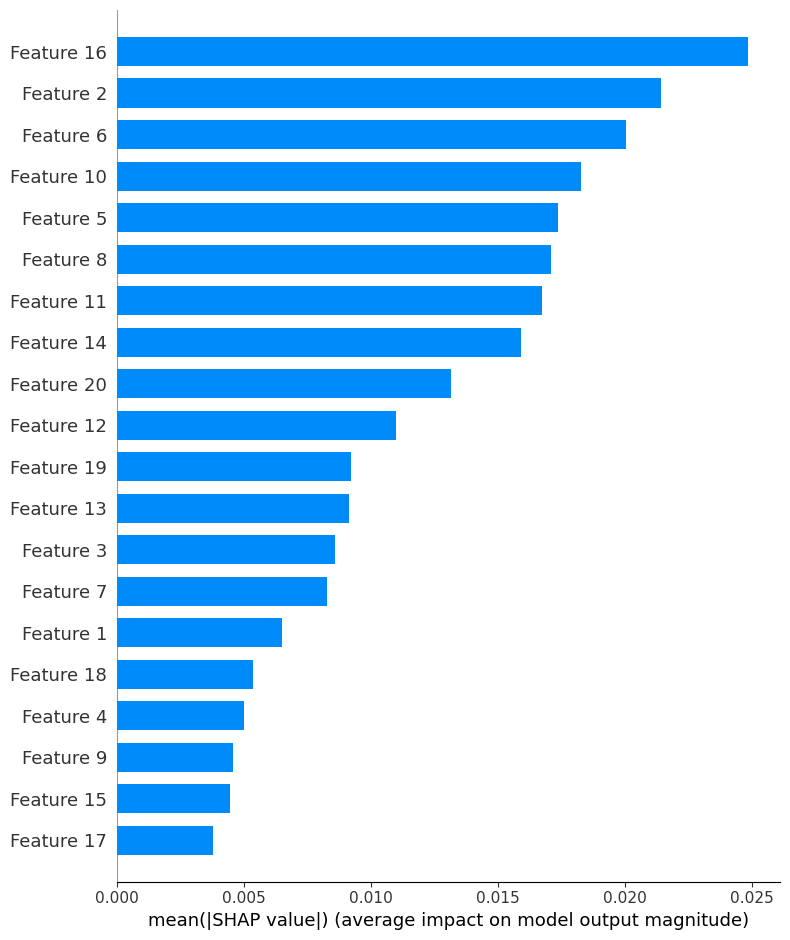

In [209]:
# loading JS visualization code to notebook
shap.initjs()
new_shap_df = []
# Iterating through samples in the dataframe:
for i in range(len(X_data)-1):
    # Applying deep explainer to get SHAP values
    e = shap.DeepExplainer(cnn_model, X_data[i][np.newaxis,...])
    shap_values = e.shap_values(X_data[i+1][np.newaxis,...])
    new_shap_df.append(shap_values[0])
# Adding shap values together for all the features:
feat_importance = np.sum(np.array(new_shap_df), axis=0)
shap.summary_plot(feat_importance[0], X_data[i], plot_type="bar");

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


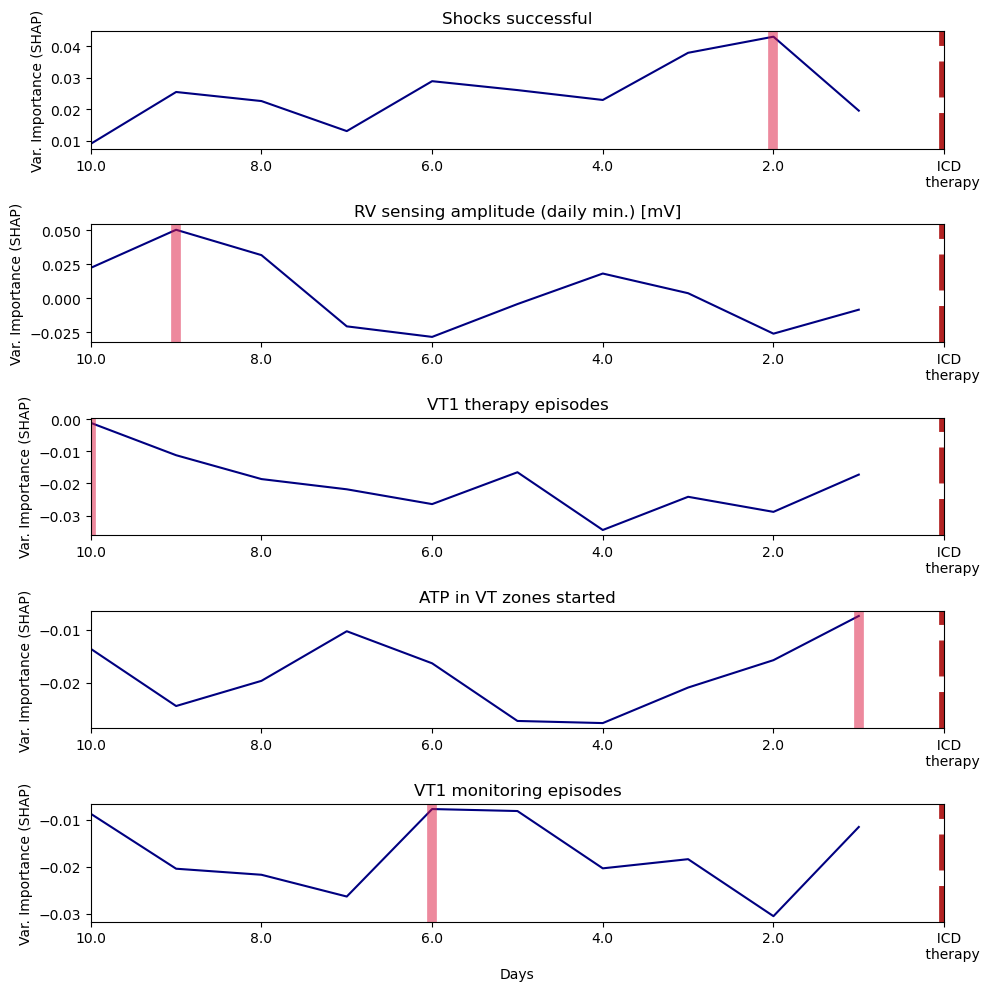

In [215]:
list_feat = [16, 2, 6, 10, 5]
feature_imp_df = pd.DataFrame(feat_importance[0], columns=VENTR_FEATURES)
# Ensuring index begins at day 1.
day_idx = range(len(feature_imp_df), 0, -1)
feature_imp_df.index = day_idx
fig, axes = plt.subplots(int(len(list_feat)), figsize=(10, 2*len(list_feat)))

# Plot each row as a time series subplot and annotate the maximum value
for idx, feature in enumerate(list_feat):
    ax = axes[idx]
    feature_imp_df[VENTR_FEATURES[feature]].plot(ax=ax, title=f'{VENTR_FEATURES[feature]}', color='navy')
    # Calculating the maximum value
    max_val = feature_imp_df[VENTR_FEATURES[feature]].max()
    max_day = feature_imp_df[feature_imp_df[VENTR_FEATURES[feature]] == max_val].index[0]
    ax.axvline(x=max_day, color='crimson', linewidth=7, alpha=0.5)
    ax.set_xlabel('')
    ax.set_ylabel('Var. Importance (SHAP)')
    # Replace 0 tic value with 'ICD therapy' in x-axis labels
    ax.set_xlim(WINDOW_SIZE, 0)
    x_ticks = ax.get_xticks().tolist()
    x_ticks[0] = '''  ICD
    therapy'''
    ax.set_xticklabels(x_ticks)
    ax.axvline(x=0, color='firebrick', linestyle='dashed', linewidth=7, label='ICD therapy')

plt.xlabel('Days')
plt.tight_layout()
plt.show()

## Other models: XGBoost, Random Forest, Logistic Regression

In [131]:
# Dataset for testing with cross validation
xgb_2d = reshape_for_resampl_mod(X_all_extr, WINDOW_SIZE)

# Datasets for optimising with optuna
xgb_2d_train = reshape_for_resampl_mod(X_train_extr, WINDOW_SIZE)
xgb_2d_test = reshape_for_resampl_mod(X_test_extr, WINDOW_SIZE)

### Optimising

##### Optimisation: XGBoost Classifier

In [740]:
def objective(trial):
    '''
    Optuna objective function for optimizing hyperparameters of a XGBoost.

    Parameters:
    -----------
    trial - optuna.Trial
        An Optuna trial object.

    Returns:
    -------
    float - ROC-AUC score.
    '''
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(xgb_2d_train, y_train_extr)

    # Make predictions
    y_pred = optuna_model.predict_proba(xgb_2d_test)

    # Evaluate predictions
    roc_xgb = roc_auc_score(y_test_extr, y_pred)
    return roc_xgb

In [741]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [742]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

In [745]:
# For 4-day model
params7 = {'max_depth': 1,
 'learning_rate': 0.06520773910225405,
 'n_estimators': 162,
 'min_child_weight': 1,
 'gamma': 5.124369393598501e-07,
 'subsample': 0.6587524404874442,
 'colsample_bytree': 0.24367631220890548,
 'reg_alpha': 0.025329771140218567,
 'reg_lambda': 0.002100208745541134}

In [ ]:
# For 10-day model
params5 = {'max_depth': 3,
 'learning_rate': 0.02516801776785153,
 'n_estimators': 227,
 'min_child_weight': 2,
 'gamma': 0.05585121004715527,
 'subsample': 0.48761747272222433,
 'colsample_bytree': 0.17490023530950663,
 'reg_alpha': 1.3318014294795547e-05,
 'reg_lambda': 0.0009058760204778298}

In [92]:
# For 30-day model
params5 = {'max_depth': 3,
 'learning_rate': 0.02516801776785153,
 'n_estimators': 227,
 'min_child_weight': 2,
 'gamma': 0.05585121004715527,
 'subsample': 0.48761747272222433,
 'colsample_bytree': 0.17490023530950663,
 'reg_alpha': 1.3318014294795547e-05,
 'reg_lambda': 0.0009058760204778298}

##### Optimisation: Random Forest Classifier

In [132]:
def objective_rf(trial):
    '''
    Optuna objective function for optimizing hyperparameters of a RandomForestClassifier.

    Parameters:
    -----------
    trial - optuna.Trial
        An Optuna trial object.

    Returns:
    -------
    float - ROC-AUC score.
    '''
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 250, 1500, step=250),
    }
    mod = RandomForestClassifier(**param)
    mod.fit(xgb_2d_train, y_train_extr)
    pred_out = mod.predict_proba(xgb_2d_test)[:,1]
    auc = roc_auc_score(y_test_extr, pred_out)
    return auc

study = optuna.create_study(direction="maximize")
study.optimize(objective_rf, n_trials=100)
trial = study.best_trial

print(f"Best AUC {trial.value}")
print("Best Params")
print(trial.params)

[I 2023-08-26 17:53:03,345] A new study created in memory with name: no-name-c23c6dec-1c4d-4c56-9e6f-c76836152dca
[I 2023-08-26 17:53:04,290] Trial 0 finished with value: 0.8393595041322315 and parameters: {'n_estimators': 500}. Best is trial 0 with value: 0.8393595041322315.
[I 2023-08-26 17:53:05,210] Trial 1 finished with value: 0.819214876033058 and parameters: {'n_estimators': 500}. Best is trial 0 with value: 0.8393595041322315.
[I 2023-08-26 17:53:08,077] Trial 2 finished with value: 0.8243801652892562 and parameters: {'n_estimators': 1500}. Best is trial 0 with value: 0.8393595041322315.
[W 2023-08-26 17:53:08,285] Trial 3 failed with parameters: {'n_estimators': 500} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/ijakaityte/opt/anaconda3/envs/sktime_code/lib/python3.8/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/jv/b4sm9rts7q947y_460yctgjc0000gn/T

KeyboardInterrupt: 

### Running the XGBoost, Random Forest models

In [216]:
classifier = xgb.XGBClassifier(**params5)
classifier = RandomForestClassifier(n_estimators=1000)

(predicted_proba, observed, roc_auc_scores, accuracy_scores, sensitivity_scores,
    specificity_scores, patient_ids, res_model) = running_resampl_models(X_all_extr,
    y_all_extr, pt_id_all, classifier, n_splits=10)

KeyboardInterrupt: 

#### Visualising feature importance with SHAP

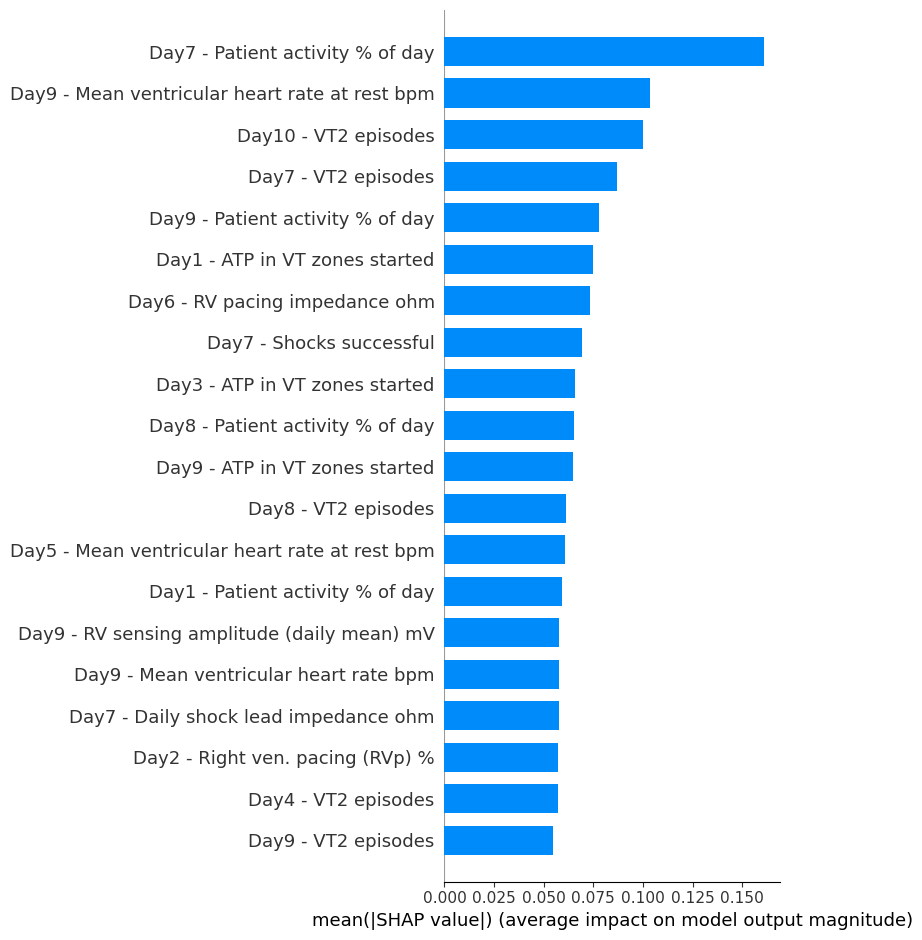

In [187]:
# load JS visualization code to notebook
classifier.fit(xgb_2d, y_all_extr)
shap.initjs()
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(xgb_2d)
shap.summary_plot(shap_values, xgb_2d, max_display=20, plot_type='bar')

In [162]:
if str(type(shap_values)) == "<class 'list'>":
    shap_values = np.absolute(shap_values[0]).mean(axis=0)
else:
    shap_values = np.absolute(shap_values).mean(axis=0)

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


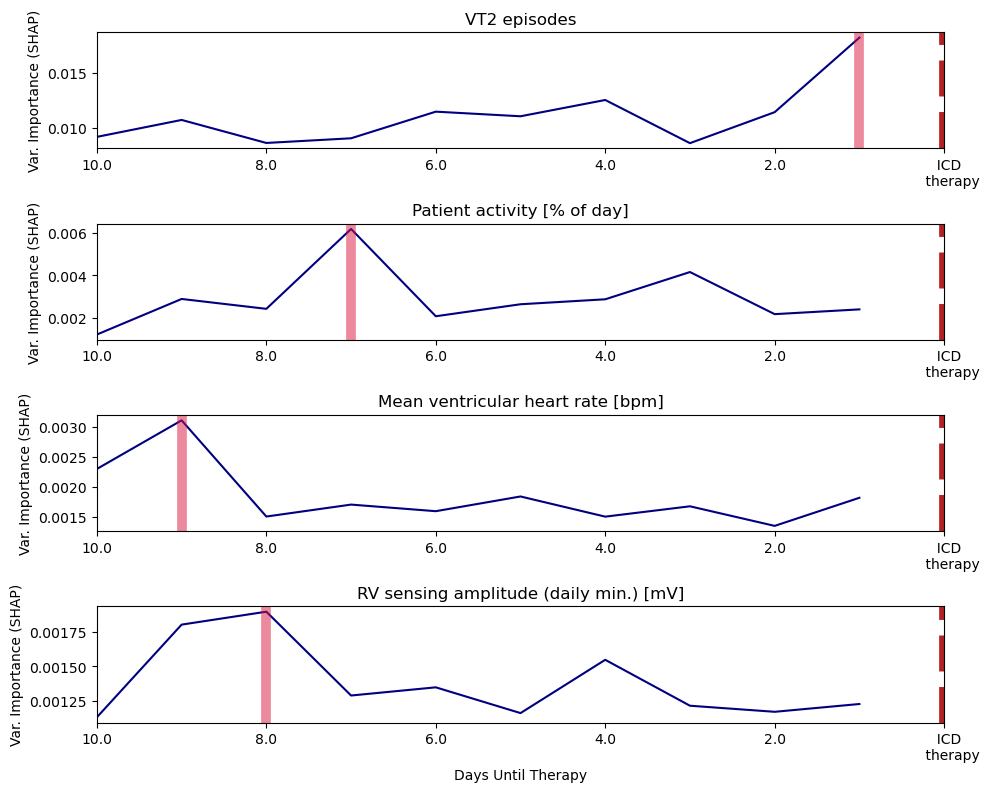

In [163]:
list_feat = ['VT2 episodes', 'Patient activity [% of day]', 'Mean ventricular heart rate [bpm]', 'RV sensing amplitude (daily min.) [mV]']
feature_imp_df = pd.DataFrame(shap_values.reshape(WINDOW_SIZE, N_FEAT), columns=VENTR_FEATURES)
# Ensuring index begins at day 1.
day_idx = range(len(feature_imp_df), 0, -1)
feature_imp_df.index = day_idx
fig, axes = plt.subplots(int(len(list_feat)), figsize=(10, 2*len(list_feat)))

# Plot each row as a time series subplot and annotate the maximum value
for idx, feature in enumerate(list_feat):
    ax = axes[idx]
    feature_imp_df[feature].plot(ax=ax, title=f'{feature}', color='navy')
    max_val = feature_imp_df[feature].max()
    max_day = feature_imp_df[feature_imp_df[feature] == max_val].index[0]
    ax.axvline(x=max_day, color='crimson', linewidth=7, alpha=0.5)
    ax.set_xlabel('')
    ax.set_ylabel('Var. Importance (SHAP)')
    # Replace 0 tic value with 'ICD therapy' in x-axis labels
    ax.set_xlim(WINDOW_SIZE, 0)
    x_ticks = ax.get_xticks().tolist()
    x_ticks[0] = '''  ICD
    therapy'''
    ax.set_xticklabels(x_ticks)
    ax.axvline(x=0, color='firebrick', linestyle='dashed', linewidth=7, label='ICD therapy')


plt.xlabel('Days Until Therapy')
plt.tight_layout()
plt.show();

#### Sensitivity/specificity

Sensitivity at 90.0% Specificity: 0.6376146788990826
Best Threshold: 0.4800
Best Sensitivity: 0.7692
Best Specificity: 0.8945


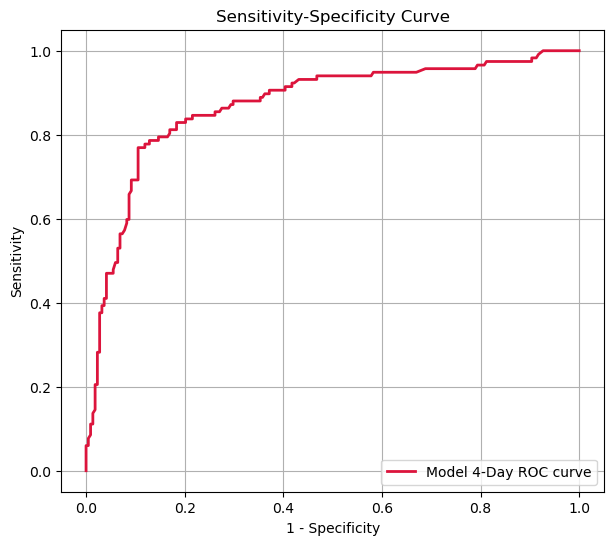

In [164]:
sensitivity, specificity = sens_spec_calculation(predicted_proba, observed, 0.9)

# Plot sensitivity-specificity curve
plt.figure(figsize=(7, 6))
plt.plot(1 - specificity, sensitivity, color='crimson', lw=2, label='Model 4-Day ROC curve')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('Sensitivity-Specificity Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### Logistic regression on features scaled by StandardScaler()

In [188]:
classifier = LogisticRegression(max_iter=1000)

(predicted_proba, observed, roc_auc_scores, accuracy_scores, sensitivity_scores,
    specificity_scores, patient_ids,res_model) = running_resampl_models(X_all_extr,
    y_all_extr, pt_id_all, classifier, n_splits=10)

ROC-AUC 95% CI: 0.535 - 0.898
Accuracy 95% CI: 0.694 - 0.926
ROC-AUC score: 0.717
Accuracy score: 0.81
Sensitivity scores: 0.319
Specificity scores: 1.0
